<a href="https://colab.research.google.com/github/pharringtonp19/rfp/blob/main/notebooks-scripts/examples/cdc_homeless_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pharringtonp19/rfp/blob/main/notebooks-scripts/training%20/standard_training.ipynb)


#### **Install Necessary Libraries**

In [1]:
!pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax flax tqdm
!pip install git+https://github.com/pharringtonp19/rfp
!pip install matplotlib

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
  Cloning https://github.com/pharringtonp19/rfp to /tmp/pip-req-build-do0y9_gn
  Running command git clone --filter=blob:none --quiet https://github.com/pharringtonp19/rfp /tmp/pip-req-build-do0y9_gn
  Resolved https://github.com/pharringtonp19/rfp to commit f011d84fcae25eeea0745845bb05d1d1c88dfea0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#### **Import Libraries**

In [2]:
import jax
jax.config.update("jax_debug_nans", True)

import flax
import optax

import jax.numpy as jnp
import numpy as np

import os
from functools import partial
import math
import pandas as pd
from collections import OrderedDict
from tqdm import tqdm
import pickle
import textwrap


from rfp import MLP, Model, ModelParams
from rfp.utils import batch_matrix_with_padding
from rfp.losses import binary_cross_entropy, Supervised_Loss, mse
from rfp.train import Trainer

#### **Define Paths**

In [3]:
import_data_link = os.getcwd() + "/cdc_homeless.csv"

#### **Plotting**

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

#### **Parameterize Notebook**

In [5]:
outcome_label = 'outcome'
outcome_documents = {
                    'outcome':
                        {'outcome_status': 'continuous',
                        'plot_labels':['Treatment Effects', 'Untreated Potential Outcome', 'Feature'],
                        'scale_factor': 1.0}}
outcome_status = outcome_documents[outcome_label]['outcome_status']
plot_labels = outcome_documents[outcome_label]['plot_labels']
scale_factor = outcome_documents[outcome_label]['scale_factor']
#causal_variable = 'treatment'
split_frac = 0.95
sims = 1
outer_epochs = 1000
nodes = 32
lr = 0.001
columns = ['income', 'Population', 'income_below_poverty_level', 'Employment_Ratio']
colors = ['#FF00FF', '#00FFFF', '#008000', '#0000FF', '#FF0000']

#### **Read In Data**

In [6]:
# Load numpy data
df = pd.read_csv(import_data_link)

# Target
Y = jnp.array(df['OverallHomeless'].values).reshape(-1,1)
print(Y.shape)

# Causal Variable
Z = jnp.array(df['cancer_mortality_rate'].values).reshape(-1,1)
print(Z.shape)

# Feature Matrix
X = jnp.array(df[columns].values)
print(X.shape)

(355, 1)
(355, 1)
(355, 4)


#### **Quantile of Outcome Variable**

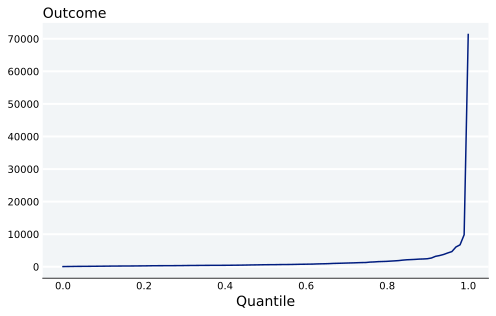

In [7]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

ax.text(0., 1.02, s='Outcome', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
qs = jnp.linspace(0., 1., 100)
plt.plot(qs, jnp.quantile(Y, qs))
plt.xlabel('Quantile', size=14)
plt.show()

#### **Filter Data**

In [8]:
# Compute 99th Quantile
qs99 = jnp.quantile(Y, 0.99)

# Create Index
idx = (Y < qs99).reshape(-1,)

# Filter Data
X = X[idx]
Y = Y[idx]
Z = Z[idx]
assert len(Y.shape) == 2
assert len(Z.shape) == 2

#### **Process Data**

In [9]:
# Feature Matrix
min_val = jnp.min(X, axis=0)
max_val = jnp.max(X, axis=0)
X_normalized = jax.nn.standardize(X, axis=0) #(X - min_val) / (max_val - min_val)
print(f"Feature shape: \t\t{X.shape}")

# Target
print(f"Outcome Shape: \t\t{Y.shape}")
Y_mean = jnp.mean(Y)
Y_std = jnp.std(Y)
Y_normalized = (Y - Y_mean)/Y_std


# Causal Variable
Z_normalized = Z / jnp.std(Z)
print(f"Causal Variable Shape:  {Z_normalized.shape}")

# Treatment ++ Instrument
XZ_normalized = jnp.hstack([X_normalized, Z_normalized])


sample_weights = jnp.ones(shape=(Z_normalized.shape[0],))

print(f"Min 'Raw' sample weight: {jnp.min(sample_weights)}, Max 'Raw' sample weight: {jnp.max(sample_weights)}")
normalized_weights = sample_weights / jnp.sum(sample_weights)

Feature shape: 		(351, 4)
Outcome Shape: 		(351, 1)
Causal Variable Shape:  (351, 1)
Min 'Raw' sample weight: 1.0, Max 'Raw' sample weight: 1.0


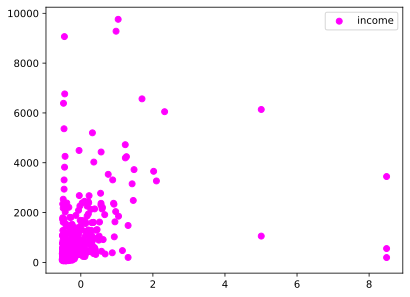

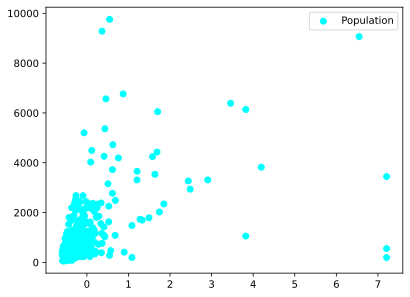

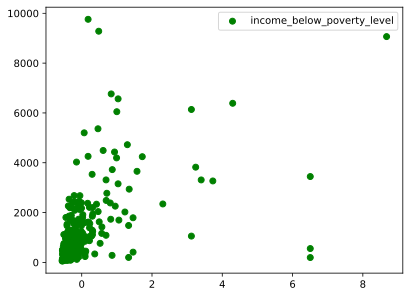

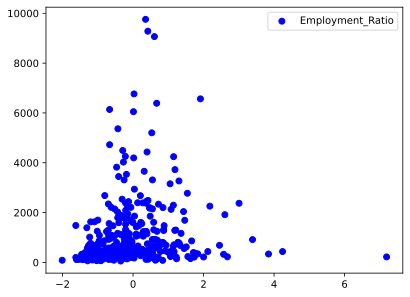

In [10]:
for i in range(X_normalized.shape[1]):
  plt.scatter(X_normalized[:,i], Y, label=columns[i], color=colors[i])
  plt.legend()
  plt.show()

#### **Model Setup**

In [11]:
features = XZ_normalized.shape[1] ; print(f"Number of Features: {features}")
mlp = MLP([nodes, nodes], jax.nn.relu)
final_activation_fn = jax.nn.sigmoid if outcome_status == 'binary' else lambda x: x; print(f"Final Activation Function: {final_activation_fn}")
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(binary_cross_entropy if outcome_status == 'binary' else mse, model.embellished_fwd_pass)
yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), outer_epochs)

Number of Features: 5
Final Activation Function: <function <lambda> at 0x7f11003ed2d0>


#### **Initial Predictions**

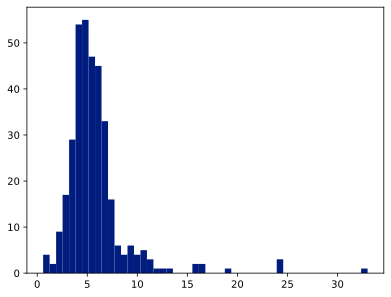

In [12]:
def hist_predictions(key):
    params = ModelParams.init_fn(key, mlp, features)
    yhat = model.fwd_pass(params, XZ_normalized)
    plt.hist(yhat.reshape(-1,), bins=50)
    plt.show()

hist_predictions(jax.random.PRNGKey(0))

#### **Initial Loss**

In [13]:
key = jax.random.PRNGKey(0)
params = ModelParams.init_fn(key, mlp, features)
supervised_loss(params, XZ_normalized, Y_normalized,  jnp.ones_like(Y_normalized))

Array(42.49301, dtype=float32)

#### **Training**

In [14]:
StandardResults = {}
key = jax.random.PRNGKey(0)
for i in tqdm(range(sims)):

    # Create Keys
    key, subkey1, subkey2, subkey3, subkey4 = jax.random.split(key, 5)

    # Initialize the parameters
    params = ModelParams.init_fn(subkey1, mlp, features)

    # Split Train and Validation Data
    idx = jax.random.permutation(subkey2, XZ_normalized.shape[0])

    # Training Indices
    train_idx = idx[:int(split_frac * XZ_normalized.shape[0])]
    p_train = normalized_weights[train_idx]/jnp.sum(normalized_weights[train_idx])
    train_idx = jax.random.choice(subkey3, train_idx, shape=(train_idx.shape[0],), p=p_train)
    is_in_train = jnp.isin(jnp.arange(XZ_normalized.shape[0]), train_idx)                                   # Check if the index is in the validation set

    # Validation Indices
    val_idx = idx[int(split_frac * XZ_normalized.shape[0]):]
    p_val = normalized_weights[val_idx]/jnp.sum(normalized_weights[val_idx])
    val_idx = jax.random.choice(subkey4, val_idx, shape=(val_idx.shape[0],), p=p_val)
    is_in_val = jnp.isin(jnp.arange(XZ_normalized.shape[0]), val_idx)                                   # Check if the index is in the validation set

    # Train the model
    params, opt_params, train_loss_history, val_loss_history = yuri.train_with_val(params, XZ_normalized, Y_normalized, jnp.ones_like(Y_normalized), is_in_train, is_in_val)
    StandardResults[i] = {'params': opt_params,
                          'train_loss_history': train_loss_history,
                          'val_loss_history': val_loss_history,
                          'val_idx': is_in_val}

100%|██████████| 1/1 [00:05<00:00,  5.90s/it]


#### **Visualize Training Runs**

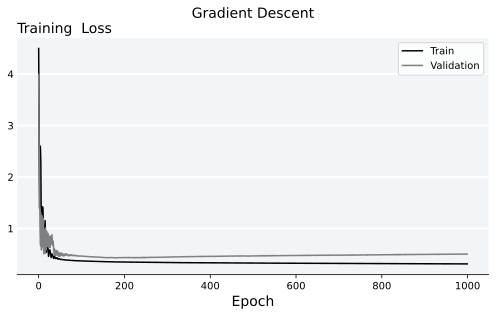

In [15]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Gradient Descent', size=14, loc='center', pad=20)

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Training  Loss', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
for i in range(jnp.minimum(10, sims)):
    if i == 0:
        plt.plot(StandardResults[i]['train_loss_history'], color='black', label='Train')
        plt.plot(StandardResults[i]['val_loss_history'], color='grey', label='Validation')
    else:
        plt.plot(StandardResults[i]['train_loss_history'], color='black')
        plt.plot(StandardResults[i]['val_loss_history'], color='grey')
plt.xlabel('Epoch', size=14)
plt.legend()
plt.show()

#### **Out of Sample Predictions**

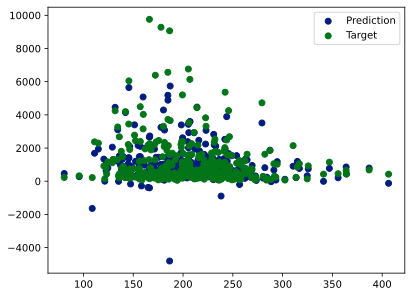

In [16]:
yhat = ((model.fwd_pass(StandardResults[0]['params'], XZ_normalized)) * Y_std) + Y_mean
plt.scatter(Z.reshape(-1,), yhat.reshape(-1,), label='Prediction')
plt.scatter(Z.reshape(-1,), Y.reshape(-1,), label='Target')
plt.legend()
plt.show()

#### **Compute Derivatives**

In [17]:
# The output of the model is (1,1) is this an issue??!
derivatives = jax.vmap(lambda i: jax.jacobian(model.fwd_pass, argnums=1)(StandardResults[0]['params'], i)[0][0][-1])(XZ_normalized)

#### **Quantile of Derivatives**

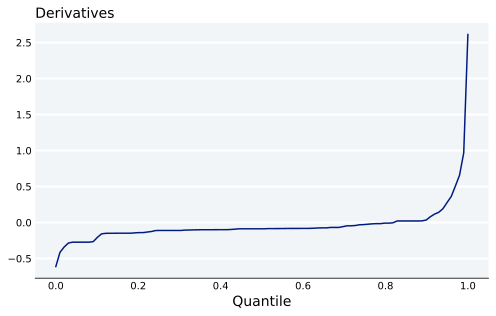

In [18]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.xaxis.set_tick_params(length=0, labeltop=False, labelbottom=True)

for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

ax.text(0., 1.02, s='Derivatives', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
qs = jnp.linspace(0., 1., 100)
plt.plot(qs, jnp.quantile(derivatives, qs))
plt.xlabel('Quantile', size=14)
plt.show()

#### **Average Derivative**

In [19]:
jnp.mean(derivatives)

Array(-0.04477075, dtype=float32)